In [1]:
import scanpy as sc
import pickle
import pandas as pd
import matplotlib
from matplotlib.transforms import Bbox
import seaborn as sns
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.manifold
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
import magic
import scprep
import scipy.sparse
import random
import math
import logging
#%matplotlib inline
#matplotlib.rcParams.update({'axes.linewidth': 0.25,'xtick.major.size': 2,'xtick.major.width': 0.25,'ytick.major.size': 2,'ytick.major.width': 0.25,'pdf.fonttype': 42, 'font.sans-serif': 'Arial'})

In [2]:
# error settings to avoid crowding the notebook
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')
os.chdir('./')

Load definitions

In [3]:
def downsample_to_smallest_category(
        adata,
        column="sample_short",
        random_state=None,
        min_cells=15,
        keep_small_categories=False
) -> sc.AnnData:
    """
    returns an annData object in which all categories in 'column' have
    the same size

    column
        column with the categories to downsample
    min_cells
        Minimum number of cells to downsample.
        Categories having less than `min_cells` are discarded unless
        keep_small_categories is True
    keep_small_categories
        Be default categories with less than min_cells are discarded.
        Set to true to keep them
    """
    counts = adata.obs[column].value_counts(sort=False)
    if len(counts[counts < min_cells]) > 0 and keep_small_categories is False:
        logging.warning(
            "The following categories have less than {} cells and will be "
            "ignored: {}".format(min_cells, dict(counts[counts < min_cells]))
        )
    min_size = min(counts[counts >= min_cells])
    sample_selection = None
    for sample, num_cells in counts.items():
        if num_cells <= min_cells:
            if keep_small_categories:
                sel = adata.obs.index.isin(
                    adata.obs[adata.obs[column] == sample].index)
            else:
                continue
        else:
            sel = adata.obs.index.isin(
                adata.obs[adata.obs[column] == sample]
                .sample(min_size, random_state=random_state)
                .index
            )
        if sample_selection is None:
            sample_selection = sel
        else:
            sample_selection |= sel
    logging.info(
        "The cells in category {!r} had been down-sampled to have each {} cells. "
        "The original counts where {}".format(column, min_size, dict(counts))
    )
    return adata[sample_selection].copy()

### Read st anndata 

In [5]:
# Load Lambda pmean df
path = '/home/svickovi/data/st_data'

# Read expression file
filename = os.path.join(path, 'anndata_colons_norm_metagenes_submodules_celltypes_kegg_degenes_pheno.h5ad')  

st_splotch_pd = sc.read_h5ad(filename)


## Get DE data from Chris

In [6]:
de_genes = pd.read_excel('/home/svickovi/data/marker_genes/DE_genes_ENS_paper.xlsx', sheet_name = 'Mouse Colon All')

In [7]:
# Only keep certain columns
aba = de_genes[['ident', 'gene', 'padjH', 'log2fc', 'mean']]

# Only save genes which have fold-change > xx
aba = aba[(aba['log2fc'] > 1) & (aba['padjH'] <0.05)]
print(len(aba['gene']))
   

2675


## Get Splotch DE genes that were processed locally

In [8]:
splotch_de = []
for key in st_splotch_pd.uns['st_modules']:
    splotch_de.append(list(st_splotch_pd.uns['st_modules'][key]))
for key in st_splotch_pd.uns['st_submodules']:
    splotch_de.append(list(st_splotch_pd.uns['st_submodules'][key]))
for key in pd.DataFrame(st_splotch_pd.uns['annotation_analysis_filtered']['names']).columns:
    tmp = list(pd.DataFrame(st_splotch_pd.uns['annotation_analysis_filtered']['names'])[key])
    splotch_de.append([x for x in tmp if x != 'nan'])
for key in pd.DataFrame(st_splotch_pd.uns['genotype_analysis_filtered']['names']).columns:
    tmp = list(pd.DataFrame(st_splotch_pd.uns['genotype_analysis_filtered']['names'])[key])
    splotch_de.append([x for x in tmp if x != 'nan'])
for key in pd.DataFrame(st_splotch_pd.uns['temporal_analysis_filtered']['names']).columns:
    tmp = list(pd.DataFrame(st_splotch_pd.uns['temporal_analysis_filtered']['names'])[key])
    splotch_de.append([x for x in tmp if x != 'nan'])

In [9]:
splotch_de = np.unique([item for sublist in splotch_de for item in sublist])

In [10]:
len(np.intersect1d(splotch_de, aba['gene']))

448

### Read  scRNA-seq data (400k cells)

In [11]:
anndata_all = sc.read_h5ad('/home/sanjavickovic/data/sc_anndatas/adata_larger_relabeling_after_tsne.h5ad')

In [12]:
anndata_all.var_names_make_unique()

In [13]:
# copy of object
adata = anndata_all.raw.to_adata()

### Downsample randomly to smallest cell type category

In [20]:
adata_sub = downsample_to_smallest_category(adata, 'pheno_cell_types', min_cells=10, keep_small_categories=True)

In [21]:
adata_sub

AnnData object with n_obs × n_vars = 28028 × 22986
    obs: 'age', 'Unique_ID', 'Mouse_ID', 'Sample_ID', '10x_version', 'Region', 'Sex', 'batch', 'doublet_scores', 'predicted_doublets', 'leiden', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_Gm', 'log1p_total_counts_Gm', 'pct_counts_Gm', 'S_score', 'G2M_score', 'phase', 'pheno', 'leiden_cell_types', 'leiden_major_cell_types', 'pheno_cell_types', 'pheno_major_cell_types'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells', 'Gm', 'ribo', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'age_colors', 'cell_type_colors', "dendrogram_['leiden_cell_types']", "dendrogram_['leiden_major_cell_types']", "dendrogram_['pheno_cell_types']", "dendrogram_['pheno_ma

In [15]:
#adata_sub = adata

Transform sc data to magic format

In [22]:
mat = pd.DataFrame.sparse.from_spmatrix(adata.X)
mat.index = adata.obs.index.tolist()
mat.columns = adata.var_names.tolist()

Normalize sc data prior to Magic

In [23]:
bmmsc_data = scprep.normalize.library_size_normalize(mat)
bmmsc_data = scprep.transform.sqrt(bmmsc_data)
bmmsc_data.head()

Xkr4  Gm1992  Gm37381  Rp1  Sox17  Gm37323  \
AAACCCAAGGAGTCTG-1-0-0  0.000000     0.0      0.0  0.0    0.0      0.0   
AAACCCATCATGCTAG-1-0-0  0.000000     0.0      0.0  0.0    0.0      0.0   
AAACGAAAGTTGGCTT-1-0-0  0.000000     0.0      0.0  0.0    0.0      0.0   
AAACGAACATTGCCGG-1-0-0  2.037848     0.0      0.0  0.0    0.0      0.0   
AAACGCTAGTAGACCG-1-0-0  4.423739     0.0      0.0  0.0    0.0      0.0   

                          Mrpl15  Lypla1  Gm37988  Tcea1  ...  Csprs  \
AAACCCAAGGAGTCTG-1-0-0  0.000000     0.0      0.0    0.0  ...    0.0   
AAACCCATCATGCTAG-1-0-0  2.306635     0.0      0.0    0.0  ...    0.0   
AAACGAAAGTTGGCTT-1-0-0  0.000000     0.0      0.0    0.0  ...    0.0   
AAACGAACATTGCCGG-1-0-0  0.000000     0.0      0.0    0.0  ...    0.0   
AAACGCTAGTAGACCG-1-0-0  0.000000     0.0      0.0    0.0  ...    0.0   

                        AC132444.6  Vamp7  CAAA01165726.1  Spry3     Tmlhe  \
AAACCCAAGGAGTCTG-1-0-0         0.0    0.0             0.0    0.0  0.000000   
AAACCCATCATGCTAG-1-0-0         0.0    0.0             0.0    0.0  1.631037   
AAACGAAAGTTGGCTT-1-0-0         0.0    0.0             0.0    0.0  0.000000   
AAACGAACATTGCCGG-1-0-0         0.0    0.0             0.0    0.0  0.000000   
AAACGCTAGTAGACCG-1-0-0         0.0    0.0             0.0    0.0  2.797819   

                        CR974586.5  CAAA01147332.1  AC125178.3  AC163611.2  
AAACCCAAGGAGTCTG-1-0-0         0.0             0.0         0.0         0.0  
AAACCCATCATGCTAG-1-0-0         0.0             0.0         0.0         0.0  
AAACGAAAGTTGGCTT-1-0-0         0.0             0.0         0.0         0.0  
AAACGAACATTGCCGG-1-0-0         0.0             0.0         0.0         0.0  
AAACGCTAGTAGACCG-1-0-0         0.0             0.0         0.0         0.0  

[5 rows x 22986 columns]

Subset data to genes present in different categories

In [24]:
'copy of data and order same as sc data'
bmmsc_magic_d = bmmsc_data
bmmsc_magic_d = bmmsc_magic_d[bmmsc_magic_d.index.isin(adata_sub.obs.index)]
'subset to de genes'
bmmsc_magic_de = bmmsc_magic_d.loc[:,bmmsc_magic_d.columns.isin(splotch_de)]
'subset to all genes that intersect between st and sc data'
bmmsc_magic_all = bmmsc_magic_d.loc[:,bmmsc_magic_d.columns.isin(list(st_splotch_pd.var_names))]
'subset to all genes that intersect chris de and st de genes'
bmmsc_magic_de_aba = bmmsc_magic_d.loc[:,bmmsc_magic_d.columns.isin(list(np.intersect1d(splotch_de, aba['gene'])))]


Subset to adata_sub cells 

In [ ]:
# 'copy of data and order same as sc data'
# bmmsc_magic_de = bmmsc_magic_de[bmmsc_magic_de.index.isin(adata_sub.obs.index)]
# bmmsc_magic_all = bmmsc_magic_all[bmmsc_magic_all.index.isin(adata_sub.obs.index)]
# bmmsc_magic_de_aba = bmmsc_magic_de_aba[bmmsc_magic_de_aba.index.isin(adata_sub.obs.index)]

In [25]:
len(bmmsc_magic_de.index) == len(adata_sub.obs.index)

True

In [26]:
len(bmmsc_magic_all.index) == len(adata_sub.obs.index)

True

In [27]:
len(bmmsc_magic_de_aba.index) == len(adata_sub.obs.index)

True

Make sure the subsetted matrix has expressed genes

In [28]:
bmmsc_magic_de = scprep.filter.filter_rare_genes(bmmsc_magic_de, min_cells=10)
bmmsc_magic_all = scprep.filter.filter_rare_genes(bmmsc_magic_all, min_cells=10)
bmmsc_magic_de_aba = scprep.filter.filter_rare_genes(bmmsc_magic_de_aba, min_cells=10)

Call Magic and run on the gene subset

In [40]:
magic_op = magic.MAGIC(knn=10,
        knn_max=30,
        decay=1,
        t=12,
        n_pca=20,
        solver="approximate",
        knn_dist="cosine",
        random_state=7,
        verbose=1,
        n_jobs=-2)

In [30]:
'performs magic on intersect of chris genes and de genes'
bmmsc_magic = magic_op.fit_transform(bmmsc_magic_de_aba) #genes = ["Actb", 'Cd8a'] # use for specific genes only
bmmsc_magic = bmmsc_magic.reindex(adata_sub.obs.index) # make sure data in same order to be able to copy obs
bmmsc_magic_adata = sc.AnnData(X = bmmsc_magic, obs = adata_sub.obs)
bmmsc_magic_adata.write('/home/sanjavickovic/data/magic_genes/magic_subset_sig_de_chris_genes.h5ad')
#bmmsc_magic.head()

Calculating MAGIC...
  Running MAGIC on 28028 cells and 448 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.67 seconds.
    Calculating KNN search...
    Calculated KNN search in 21.72 seconds.
    Calculating affinities...
    Calculated affinities in 21.43 seconds.
  Calculated graph and diffusion operator in 44.97 seconds.
  Calculating imputation...
  Calculated imputation in 0.22 seconds.
Calculated MAGIC in 45.29 seconds.


In [31]:
'performs magic on st de genes'
bmmsc_magic = magic_op.fit_transform(bmmsc_magic_de) #genes = ["Actb", 'Cd8a'] # use for specific genes only
bmmsc_magic = bmmsc_magic.reindex(adata_sub.obs.index)
bmmsc_magic_adata = sc.AnnData(X = bmmsc_magic, obs = adata_sub.obs)
bmmsc_magic_adata.write('/home/sanjavickovic/data/magic_genes/magic_subset_sig_de_only_genes.h5ad')

Calculating MAGIC...
  Running MAGIC on 28028 cells and 3854 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 6.39 seconds.
    Calculating KNN search...
    Calculated KNN search in 20.31 seconds.
    Calculating affinities...
    Calculated affinities in 20.33 seconds.
  Calculated graph and diffusion operator in 47.68 seconds.
  Calculating imputation...


/home/sanjavickovic/.local/lib/python3.7/site-packages/magic/magic.py:462: UserWarning: Returning imputed values for all genes on a (28028 x 3854) matrix will require approximately 0.80GB of memory. Suppress this warning with `genes='all_genes'`
  UserWarning,


  Calculated imputation in 0.21 seconds.
Calculated MAGIC in 48.48 seconds.


In [42]:
'performs magic on intersect of all st and sc genes'
bmmsc_magic = magic_op.fit_transform(bmmsc_magic_all) #genes = ["Actb", 'Cd8a'] # use for specific genes only
bmmsc_magic = bmmsc_magic.reindex(adata_sub.obs.index)
bmmsc_magic_adata = sc.AnnData(X = bmmsc_magic, obs = adata_sub.obs)
bmmsc_magic_adata.write('/home/sanjavickovic/data/magic_genes/magic_subset_sig_all_genes.h5ad')

Calculating MAGIC...
  Running MAGIC on 28028 cells and 6814 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 12.07 seconds.
    Calculating KNN search...
    Calculated KNN search in 19.01 seconds.
    Calculating affinities...
    Calculated affinities in 18.82 seconds.
  Calculated graph and diffusion operator in 50.80 seconds.
  Calculating imputation...


/home/sanjavickovic/.local/lib/python3.7/site-packages/magic/magic.py:462: UserWarning: Returning imputed values for all genes on a (28028 x 6814) matrix will require approximately 1.42GB of memory. Suppress this warning with `genes='all_genes'`
  UserWarning,


  Calculated imputation in 0.20 seconds.
Calculated MAGIC in 52.03 seconds.


Plot genes before and after Magic

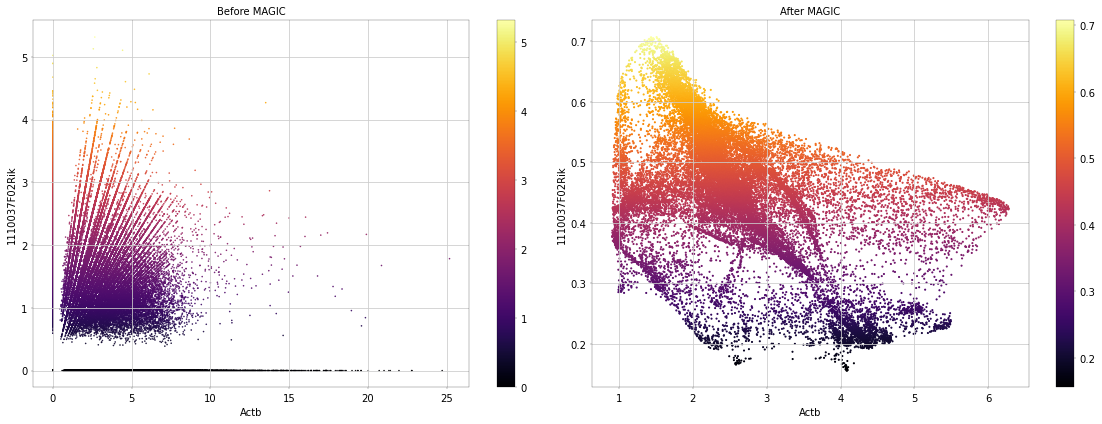

In [44]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

# scprep.plot.scatter(x=bmmsc_data['Actb'], y=bmmsc_data['1110037F02Rik'], c=bmmsc_data['1110037F02Rik'],  ax=ax1,
#                     xlabel='Actb', ylabel='1110037F02Rik', title='Before MAGIC')

# scprep.plot.scatter(x=bmmsc_magic['Actb'], y=bmmsc_magic['1110037F02Rik'], c=bmmsc_magic['1110037F02Rik'], ax=ax2,
#                     xlabel='Actb', ylabel='1110037F02Rik',  title='After MAGIC')

# plt.tight_layout()
# plt.show()